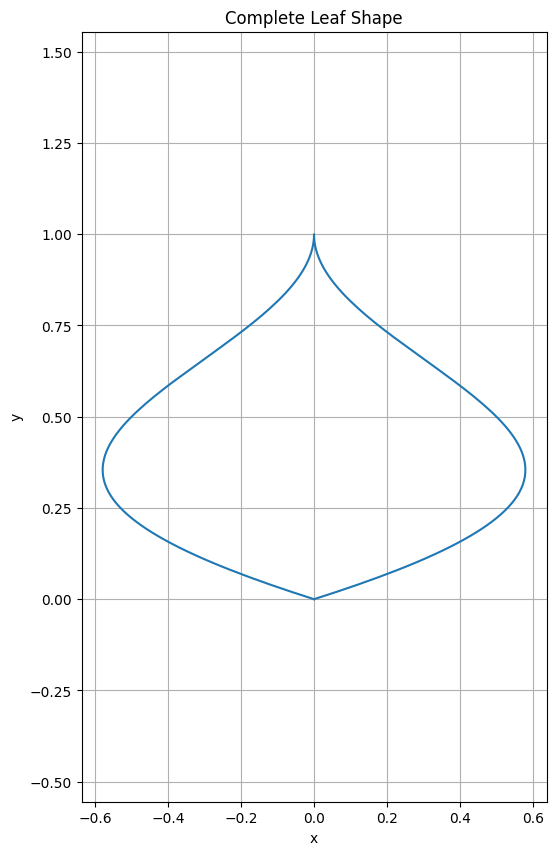

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Create points for the curve
t = np.linspace(0, 1, 100)  # 100 points from 0 to 1
x = np.sin(np.pi * t) * (1 - t)
y = t

# Create the mirror image by reversing the sign of x
# This combines the right side (original x values) with the left side (-x values)
x_full = np.concatenate([x, -x[::-1]])  # [::-1] reverses the array
y_full = np.concatenate([y, y[::-1]])   # Mirror the y values too to complete the loop

# Plot the complete leaf shape
plt.figure(figsize=(6, 10))  # Make the figure taller than wide, like a leaf
plt.plot(x_full, y_full)
plt.title("Complete Leaf Shape")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('equal')  # This ensures the aspect ratio is 1:1
plt.show()